# Correct Consensus and Stochastic Error

## Background

Show the irreducible error of vanilla ATC algorithm + stochastic gradient

## SVRG
 
Algorithm correct the stochastic gradient noise

## Exact Diffusion

Correct the consensus error

**Coding consideration**
Maybe more advanced skill of Bluefog and torch usage?

## Combined algorithm

Correct both error

The logistic problem discussed in Section 3 is an example of a finite sum problem. The finite sum problem is the minimization of an average of functions.
\begin{equation*}
    f(x) = \min_{x} \frac{1}{M} \sum_{i=1}^{M} f_i(x)
\end{equation*}
In a machine learning setting where there is a set of $M$ data points, we can interpret this problem as minimizing the average of $M$ error functions $f_i$ evaluated at the corresponding $i$th data point. The logistic regression problem we solved was a special case where each $f_i$ is $L_i$-smooth and $f(x)$ is $\mu$-strongly convex.

A common method of solving this problem is the Gradient Descent method. The gradient descent update can be written as follows:
\begin{equation*}
    x^{(k)} = x^{(k -1)} - t_k \frac{1}{M} \sum_{i=1}^{M}\nabla f_i(x^{(k-1)}), k = 1, 2, 3
\end{equation*}

It is known that the Gradient Descent method has the following properties:

- Convergence rate: linear rate, $\mathbb{O}((\frac{\kappa - 1}{\kappa + 1})^{2k})$ where $\kappa = \frac{L}{\mu}$ for $t = \frac{2}{\mu + L}$ 
- Iteration cost: $\mathbb{O}(N)$ i.e $N$ gradients are computed at each iteration

A problem with the Gradient Descent method is that the iteration cost is very high when the amount of data ($M$) is large. An alternative algorithm to Gradient Descent is Stochastic Gradient Descent (SGD). The idea of SGD is very simple. Instead of finding the gradient for all the objective functions we uniformly and randomly choose one to calculate the gradient and use in our update.

We can express this formally. Let $I$ be a uniform discrete variable such that $\mathbb{P}(I=i) = \frac{1}{N}$. Then we have the following update rule:
\begin{equation}
    x^{(k)} = x^{(k -1)} - t_k \nabla f_{i_k}(x^{k-1}) \; \text{where} \; k = 1, 2, 3, \; i_k \sim I
\end{equation}
The corresponding error function $f_i$ for the iteration is chosen uniformly from the entire set of error functions $\{i = 1,2,...,M\}$. To be even more general, we can train in a batch setting. This means that at each iteration we uniformly sample a small batch $B \subseteq \{1,2, ..., M\}$. The update in this case is
\begin{equation*}
    x^{(k)} = x^{(k -1)} - t_k \frac{1}{|B|} \sum_{i \in B}^{}\nabla f_i(x^{(k-1)}), k = 1, 2, 3
\end{equation*}

SGD works as the stochastic gradient is an unbiased estimator of the full gradient:
\begin{equation*}
    \mathbb{E} \left[\frac{1}{|B|}\sum_{i \in B}^{}\nabla f_i(x^{k-1})\right] = \frac{1}{M}\sum_{i=1}^{M}\nabla f_i(x) = \nabla g(x^{k-1})
\end{equation*}
The problem with this type of update is that by randomly sampling $\nabla f_i$ and using it as our gradient we can potentially use an estimator that has a large variance. This variance, unlike the bias of the estimator, does not converge to 0 with more iterations. As a result, noise is introduced that prevents the algorithm from converging quickly. A possible fix would be employ a decaying step size but for online problems this removes the adaptability of the model and also prevents linear convergence.

Stochastic gradient descent satisfies:

- Convergence rate: sub-linear rate $\mathbb{O}$ $(\frac{1}{t})$
- Iteration cost: $\mathbb{O}(1)$

We want the linear rate of gradient descent with the iteration cost of stochastic gradient descent. Hence, we introduce variance reduced methods, a hybrid between the two.

We will now provide intuition on how variance reduction works. First, we consider an estimator X for a parameter $\phi$. If X is an unbiased estimator, then we have $\mathbb{E}[X] = \phi$. Now we introduce a modified estimator: $Z:= X - Y$ where Y is a random variable such that $\mathbb{E}[Y] = 0$. If that is the case, then the bias of $Z$ will be $0$ as $\mathbb{E}[Z] = \mathbb{E}[X] - \mathbb{E}[Y] = \phi$. The variance of $Z$ would be $Var(X-Y) = Var(X) + Var(Y) - 2Cov(X,Y)$ which can be much less than the variance of $X$ if the random variable $Y$ is highly correlated with $X$. This means that for an estimator $X$, we can reduce its variance by introducing a random variable $Y$ that satisfies

- $\mathbb{E}[Y]$ close to or exactly 0
- a high correlation with the random variable $X$

This idea will serve as the basis for SVRG.

The SVRG algorithm works as follows. 

 Parameters: update frequency n and learning rate t  
 Initialize $\tilde{x}^{(0)}$  
 For k = 1,2,...   
  &emsp;&emsp;$\tilde{x}^{(k)} = \tilde{x}^{(k-1)}$   
  &emsp;&emsp;$\tilde{d} = \frac{1}{M} \sum_{i=1}^{M} \nabla f_i(\tilde{x}^{(k)})$  
  &emsp;&emsp;$x^{(0)} = \tilde{x}^{(k)}$  
  &emsp;For l = 1,2,...,z    
  &emsp;&emsp;&emsp;&emsp;Sample a new $b$ from $\{1,2,...,M\}$  
  &emsp;&emsp;&emsp;&emsp;Update: $x^{(l)} = x^{(l-1)} - \gamma \left( \nabla f_b(x^{(l-1)}) - \nabla f_b(\tilde{x}^{(k)}) + \tilde{d}\right)$  
  &emsp;&emsp;Update $\tilde{x}^{(z)}$   
  &emsp;&emsp;&emsp;&emsp;Option I: $\tilde{x}^{(k)} = x^{(z)}$  
  &emsp;&emsp;&emsp;&emsp;Option II: $\tilde{x}^{(k)} = \frac{1}{z} \sum_{l = 1}^{z} x^{(l)}$  
  &emsp;&emsp;&emsp;&emsp;Option III: $\tilde{x}^{(k)} = x^{f}$ for random chosen $f \in \{1,2,...,z\}$  

In [1]:
import ipyparallel as ipp
import numpy as np
import torch
import networkx as nx   # nx will be used for network topology creating and plotting
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
%matplotlib inline

In [2]:
rc = ipp.Client(profile='bluefog')
rc.ids

[0, 1, 2, 3]

In [3]:
%%px
import numpy as np
import bluefog.torch as bf
import torch
from bluefog.common import topology_util
import networkx as nx
from sklearn.preprocessing import normalize

bf.init()
print(f"Hello, I am {bf.rank()} among {bf.size()} processes")

[stdout:0] Hello, I am 0 among 4 processes
[stdout:1] Hello, I am 2 among 4 processes
[stdout:2] Hello, I am 1 among 4 processes
[stdout:3] Hello, I am 3 among 4 processes


We will reuse the functions from Section 3 that were used to build a logistic regression model. Since we are going to compare Gradient Descent (GD), Stochastic Gradient Descent (SGD), and Stochastic Variance-Reduced Gradient Descent (SVRG), we will not use multiple processes and instead run it on a single process.

In [4]:
# Implement functions for logistic regression.

def sigmoid(x):
    '''Return the output of the sigmoid function.
    Args:
     - x (torch tensor): Input that we want to apply the sigmoid function on.
    Return:
    - Return a torch tensor of the output 
        
    '''
    return 1.0 / (1.0 + torch.exp(-x))

def obj(w, X, y, reg):
    '''Output of the objective function of logistic regression.
    Args:
     - w (torch tensor): Parameter.
     - X (torch tensor): Data.
     - y (torch tensor): Labels.
     - reg (float): Regularization parameter.
    Return:
     - Returns a float of the value of the objective function.
    '''
    M, _ = X.shape
    return 1/M * torch.sum(torch.log(1 + torch.exp(-y * X @ w))) + 1/2 * reg * w.T @ w 

def grad(w, X_batch, y_batch, reg):
    '''Output of the gradient for the logistic regression.
    Args:
     - w (torch tensor): Parameter.
     - X_batch (torch tensor): Batch of data gradient is calculated on.
     - y_batch (torch tensor): Labels.
     - reg (float): Regularization parameter.
    Return:
     - Returns a torch tensor that is the gradient for the data and parameters provided.
    '''
    M_batch, _ = X_batch.shape
    return 1/M_batch * X_batch.T @ (y_batch * (sigmoid(y_batch * X_batch @ w) - 1)) + reg * w

In [5]:
dview = rc[:] # A DirectView of all engines
dview.block=True

In [6]:
dview.push({'sigmoid': sigmoid, 'obj': obj, 'grad': grad})

[None, None, None, None]

In the following cell, we generate synthetic data for us to train our logistic regression model on much like the previous section. However, two key distinctions are that we increased the dimensions and all the data is on one process.

In [7]:
# Generate the data for each worker. Each worker will have data from a different distribution.

M = 10000     # N (int) := Number of data points.
dim = 25    # dim (int) := Dimension of a data point.
reg = 1e-4     # reg (float) := Regularization parameter.
np.random.seed(0)     # Set seed.
torch.manual_seed(0)     # Set seed.


w_param = np.random.multivariate_normal([0.0]*dim, np.eye(dim), 1).T     # w (np.array) := Parameters of size (dim, 1).
X = np.random.multivariate_normal([0.0]*dim, np.eye(dim), size = M)     # X (np.array) := Data of size (M, dim).
X = normalize(X, axis = 1, norm = 'l2')     # Normalize the data.
y = 2 * (np.random.uniform(size = (M, 1)) < 1.0 / (1.0 + np.exp(X @ w_param))) - 1 # y (np.array) := Labels of data of size (M, 1).

# Convert the data into tensors.
w_param_tensor = torch.Tensor(w_param).to(torch.float32)
X_tensor = torch.Tensor(X).to(torch.float32)
y_tensor = torch.Tensor(y).to(torch.float32)

We first establish the Lipshitz constant for the Logistic Regression problem that is used to determine the step-size for Gradient Descent.

In [8]:
L = reg + 1/4

We use GD for many iterations to find the optimal solution. We confirm the optimality of the solution by checking the L2-norm of the gradient.

In [9]:
w_opt = torch.zeros(dim , 1)
for i in range(10000):
    w_opt = w_opt - 2 / (L + reg) * grad(w_opt, X_tensor, y_tensor, reg)
    
print(f"L2-Norm of the Gradient {torch.norm(grad(w_opt, X_tensor, y_tensor, reg), p=2)}")

L2-Norm of the Gradient 2.99185280994152e-08


Full Gradient Descent (GD)  

Here our goal is to run GD, SGD, and SVRG for the same number of iterations in order to compare performance in terms of number of epochs and accuracy. An epoch is one pass through the data. The accuracy is measured in terms of MSE 

In [10]:
w_GD = torch.zeros(dim , 1)
MSE_GD = []
for i in range(50):
    MSE_GD.append(torch.norm(w_opt - w_GD, p=2))
    w_GD = w_GD - 2 / (L + reg) * grad(w_GD, X_tensor, y_tensor, reg)

In [11]:
w_SGD = torch.zeros(dim, 1)
MSE_SGD = []
batch_size = 50
iters = int(M/batch_size)
for i in range(50):
    
    MSE_SGD.append(torch.norm(w_opt - w_SGD, p=2))
    
    for j in range(iters):
        rand_idx = torch.randint(0, M-1, (batch_size, ))
        X_batch = X_tensor[rand_idx, :]
        y_batch = y_tensor[rand_idx]
        w_SGD = w_SGD - 0.1 / (reg*(j+100)) * grad(w_SGD, X_batch, y_batch, reg)

In [12]:
w_SVRG = torch.zeros(dim, 1)
batch_size = 50
iters = int(M/batch_size)
MSE_SVRG = []
passes_SVRG = []
for i in range(25):
    passes_SVRG.append(i*2)
    MSE_SVRG.append(torch.norm(w_opt - w_SVRG, p=2))
    MSE_SVRG.append(torch.norm(w_opt - w_SVRG, p=2))
    w_old = w_SVRG
    gradient_control = grad(w_old, X_tensor, y_tensor, reg)
    passes_SVRG.append(i*2+1)
    
    for j in range(iters):
        rand_idx = torch.randint(0, M-1, (batch_size, ))
        X_batch = X_tensor[rand_idx, :]
        y_batch = y_tensor[rand_idx]
        w_SVRG = w_SVRG - 1 / L * (grad(w_SVRG, X_batch, y_batch, reg) - grad(w_old, X_batch, y_batch, reg) + gradient_control)

Text(0, 0.5, 'MSE')

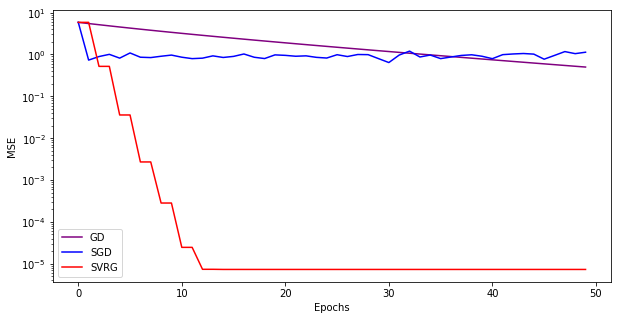

In [13]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()
ax.semilogy(range(len(MSE_GD)), MSE_GD, color = 'purple', label='GD')
ax.semilogy(range(len(MSE_SGD)), MSE_SGD, color = 'blue', label='SGD')
ax.semilogy(range(len(MSE_SVRG)), MSE_SVRG, color = 'red', label='SVRG')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')

Recall the aggregrate optimization problem presented in Section 3 where we considered N workers: 

$$\min_w J(w) := \sum_{n=1}^{N} g_n(w)$$

A more general form of this problem is

$$\min_w J(w) := \sum_{n=1}^{N} q_n g_n(w)$$ where $$\sum_{n=1}^{N} q_n = 1$$

Consensus and diffusion strategies for solving this problem converges with some bias towards the optimal solution. The source of this bias is not the gradient noise from the use of stochastic approximations which, as discuessed earlier, can be corrected through variance reduction techniques. Rather this bias comes from the inherent structure of the diffusion and consensus updates. To correct this for the diffusion approach, we use Exact Diffusion. Exact diffusion follows the following structure:

Setting: Let $\bar{A} = \frac{(I_N + A)}{2}$ where $A$ is the adjacency matrix and $I_N$ is the identity matrix of size $N \times N$. Let $w_{n,-1}$ be set arbitrarily where $n$ is the index of the worker. Set $\psi_{n, -1} = w_{n, -1}$. Let $\mu_n = \frac{q_n \mu_0}{p_n}$. $p_n = \frac{q_n/\mu_n}{\sum_{l=1}^{N}q_l/\mu_l}$ and $\mu_n = (\frac{q_n}{p_n}\mu_0)$ where $\mu_0>0$ is a small step-size.  

Repeat for i=0,1,2,...  

$\psi_{n,i} = w_{n, i-1} - \mu_n \nabla g_n(w_{n, i-1})$ (Adaptation)  
$\phi_{n,i} = \psi_{n,i} + w_{n,i-1} - \psi_{n, i-1}$ (Correction)  
$w_{n,i} = \sum_{l \in \mathbb{N}_n} \bar{a}_{ln}\phi_{l, i}$ (Combination)

In [14]:
%%px 

# Generate the data for each worker. Each worker will have data from a different distribution.

M = 8000     # N (int) := Number of data points.
dim = 10     # dim (int) := Dimension of a data point.
reg = 1e-4     # reg (float) := Regularization parameter.
np.random.seed(0)     # Set seed.
torch.manual_seed(0)     # Set seed.


w_param = np.random.multivariate_normal([0.0]*dim, np.eye(dim), 1).T     # w (np.array) := Parameters of size (dim, 1).
# X = np.random.multivariate_normal([float(bf.rank())]*dim, np.eye(dim), size = M)     # X (np.array) := Data of size (M, dim).
X = np.random.multivariate_normal([0.0]*dim, np.eye(dim), size = M) 
X = normalize(X, axis = 1, norm = 'l2')     # Normalize the data.
y = 2 * (np.random.uniform(size = (M, 1)) < 1.0 / (1.0 + np.exp(X @ w_param))) - 1 # y (np.array) := Labels of data of size (M, 1).

# Convert the data into tensors.
w_param_tensor = torch.Tensor(w_param).to(torch.float32)
X_tensor = torch.Tensor(X).to(torch.float32)
y_tensor = torch.Tensor(y).to(torch.float32)

In [15]:
%%px

# Create a distributed gradient descent function that is equivalent to centralized gradient descent.
def distributed_grad_descent(X, y, reg=1e-4, maxite=10000, step_size=1e-1):
    M, dim = X.shape
    w_opt = 0.001 * torch.randn((dim, 1))
    for i in range(maxite):
        # Calculate local gradient.
        grad_iter = grad(w_opt, X, y, reg)
        # Use local gradient to calculate global gradient.
        gradient = bf.allreduce(grad_iter)
        
        # Distributed gradient descent.
        w_opt = w_opt - step_size * gradient
    print(f"[DG] Rank {bf.rank()}: Global Gradient Norm: {torch.norm(gradient, p=2)}")
    return w_opt

In [16]:
%%px

# Find the optimal solution.
w_opt = distributed_grad_descent(X_tensor, y_tensor)

print(w_opt)

[stdout:0] 
[DG] Rank 0: Global Gradient Norm: 1.6457101992273238e-06
tensor([[-1.7794],
        [-0.3855],
        [-0.8945],
        [-2.2765],
        [-1.7099],
        [ 1.0551],
        [-0.9216],
        [ 0.0216],
        [ 0.1668],
        [-0.3453]])
[stdout:1] 
[DG] Rank 2: Global Gradient Norm: 1.6457101992273238e-06
tensor([[-1.7794],
        [-0.3855],
        [-0.8945],
        [-2.2765],
        [-1.7099],
        [ 1.0551],
        [-0.9216],
        [ 0.0216],
        [ 0.1668],
        [-0.3453]])
[stdout:2] 
[DG] Rank 1: Global Gradient Norm: 1.6457101992273238e-06
tensor([[-1.7794],
        [-0.3855],
        [-0.8945],
        [-2.2765],
        [-1.7099],
        [ 1.0551],
        [-0.9216],
        [ 0.0216],
        [ 0.1668],
        [-0.3453]])
[stdout:3] 
[DG] Rank 3: Global Gradient Norm: 1.6457101992273238e-06
tensor([[-1.7794],
        [-0.3855],
        [-0.8945],
        [-2.2765],
        [-1.7099],
        [ 1.0551],
        [-0.9216],
        [ 0.02

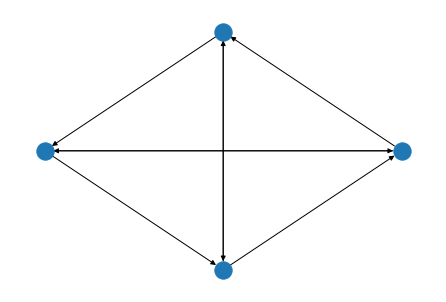

In [17]:
# Generate topology.

# Plot figure
%px G = topology_util.ExponentialTwoGraph(bf.size())

G_0 = dview.pull('G', block=True, targets=0)
nx.draw_circular(G_0)

In [18]:
%%px

# set topology as exponetial-2 graph
bf.set_topology(G)
topology = bf.load_topology()
self_weight, neighbor_weights = topology_util.GetRecvWeights(topology, bf.rank())

# scale weights
if bf.rank() == 0:
    print('self weights: {}\n'.format(self_weight))
    print('neighbor weights:')
    for k, v in neighbor_weights.items():
        print(k, v)
        
self_weight = (self_weight+1)/2
for k, v in neighbor_weights.items():
    neighbor_weights[k] = v/2
    
if bf.rank() == 0:
    print('self weights: {}\n'.format(self_weight))
    print('neighbor weights:')
    for k, v in neighbor_weights.items():
        print(k, v)

[stdout:0] 
self weights: 0.3333333333333333

neighbor weights:
2 0.3333333333333333
3 0.3333333333333333
self weights: 0.6666666666666666

neighbor weights:
2 0.16666666666666666
3 0.16666666666666666


In [19]:
%%px

def exact_diffusion(X, y, w_opt, w=None, psi=None, phi=None, batch_size=500, reg=1e-4, alpha=0.1):
    '''Perform one iteration of Exact Diffusion.
    Args:
     - X (torch tensor): Data.
     - y (torch tensor): Labels.
     - w_opt (torch tensor): Optimal parameters.
     - w (torch tensor): Parameter.
     - psi (torch tensor): Adaptation parameter.
     - phi (torch tensor): Correction parameter.
     - batch_size(int): Size of batch.
     - reg (float): Regularization parameter.
     - alpha (float): Step-size parameter.
    Return:
     - w (torch tensor)
    '''
    M, dim = X.shape
    
    if w is None:
        w = torch.zeros(dim, 1)
    
    if psi is None:
        psi = w.clone()
    
    if phi is None:
        phi = w.clone()
        
    psi_old = psi.clone()

        
#     rand_idx = torch.randint(0, M-1, (batch_size, ))
#     X_batch = X[rand_idx, :]
#     y_batch = y[rand_idx]
    
    psi = w - alpha * grad(w, X, y, reg)
    phi = psi + w - psi_old
    w = bf.neighbor_allreduce(phi, self_weight, neighbor_weights)
    
    dist = torch.norm(w - w_opt, p=2)/torch.norm(w_opt, p=2)
    averaged_relative_error = bf.allreduce(dist**2, average=True)
    
    return w, psi, phi, torch.sqrt(averaged_relative_error)

In [20]:
# Run the Exact Diffusion

maxite = 5000
relative_error = torch.zeros((maxite, 1))
%px w = None
%px psi = None
%px phi = None
for ite in range(maxite):
    
    if ite%100 == 0:
        print('Progress {}/{}'.format(ite, maxite))
    
    %px w, psi, phi, relative_error_ite = exact_diffusion(X_tensor, y_tensor, w_opt, w=w, psi=psi, phi=phi, batch_size=M)
    relative_error[ite] = dview.pull('relative_error_ite', block=True, targets=0)

Progress 0/5000
Progress 100/5000
Progress 200/5000
Progress 300/5000
Progress 400/5000
Progress 500/5000
Progress 600/5000
Progress 700/5000
Progress 800/5000
Progress 900/5000
Progress 1000/5000
Progress 1100/5000
Progress 1200/5000
Progress 1300/5000
Progress 1400/5000
Progress 1500/5000
Progress 1600/5000
Progress 1700/5000
Progress 1800/5000
Progress 1900/5000
Progress 2000/5000
Progress 2100/5000
Progress 2200/5000
Progress 2300/5000
Progress 2400/5000
Progress 2500/5000
Progress 2600/5000
Progress 2700/5000
Progress 2800/5000
Progress 2900/5000
Progress 3000/5000
Progress 3100/5000
Progress 3200/5000
Progress 3300/5000
Progress 3400/5000
Progress 3500/5000
Progress 3600/5000
Progress 3700/5000
Progress 3800/5000
Progress 3900/5000
Progress 4000/5000
Progress 4100/5000
Progress 4200/5000
Progress 4300/5000
Progress 4400/5000
Progress 4500/5000
Progress 4600/5000
Progress 4700/5000
Progress 4800/5000
Progress 4900/5000


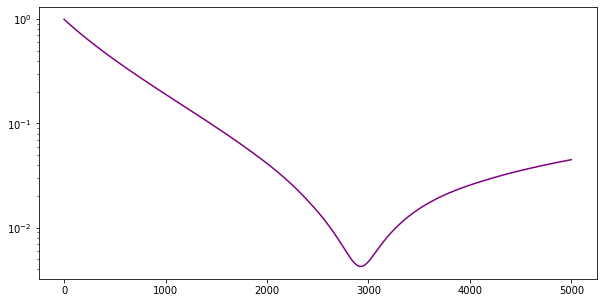

In [21]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()
ax.semilogy(range(len(relative_error)), relative_error, color = 'purple')

In [26]:
%%px
def obj_autograd(w, X, y, reg):
    '''Output of the objective function of logistic regression.
    Args:
     - w (torch tensor): Parameter.
     - X (torch tensor): Data.
     - y (torch tensor): Labels.
     - reg (float): Regularization parameter.
    Return:
     - Returns a float of the value of the objective function.
    '''
    M, _ = X.shape
    loss = 1/M * torch.sum(torch.log(1 + torch.exp(-y * X @ w))) + 1/2 * reg * w.T @ w 
    loss.backward()
    
def exact_diffusion(X,y,w_opt,reg,maxite=5000, alpha=1e-1):
    M, dim = X.shape
    w = torch.zeros(dim, 1, requires_grad=True)
    phi, psi, psi_prev = w.data, w.data, w.data
    relative_error = []

    for i in range(maxite):
        # calculate local gradient via pytorch autograd
        obj_autograd(w, X, y, reg)

        # exact diffusion
        with torch.no_grad():
            psi = w.data - alpha * w.grad.data
            phi = psi + w.data - psi_prev
            w.data = bf.neighbor_allreduce(
                phi, self_weight, neighbor_weights, name='local variable')
            psi_prev = psi.clone()
            w.grad.data.zero_()

            dist = torch.norm(w.data - w_opt, p=2)/torch.norm(w_opt, p=2)
            averaged_relative_error = bf.allreduce(dist**2, average=True)
            relative_error.append(torch.sqrt(averaged_relative_error))

    return w, relative_error

In [27]:
%%px

w, relative_error_new = exact_diffusion(X_tensor, y_tensor, w_opt, 1e-4)

In [28]:
relative_error_new = dview.pull('relative_error_new', block=True, targets=0)

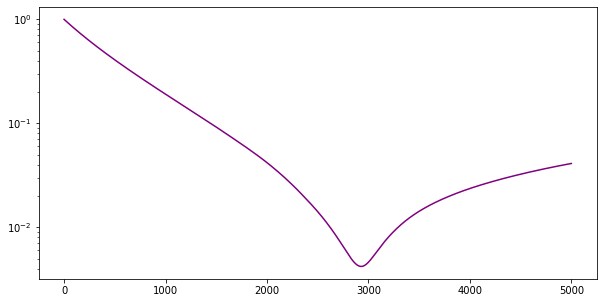

In [29]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()
ax.semilogy(range(len(relative_error_new)), relative_error_new, color = 'purple')